In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [ ]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Water Level/NTWL/Faridpur-Padma.csv')
#the daily dataset
print(df.shape)
df.head()

(18226, 2)


,Date,WL(m)
0,1965-04-01,2.29
1,1965-04-02,2.37
2,1965-04-03,2.44
3,1965-04-04,2.52
4,1965-04-05,2.55


In [ ]:
#checking types
df.dtypes

Date      object
WL(m)    float64
dtype: object

Data Preprocessing
---------

In [ ]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

             Date  WL(m)
0      1965-04-01  2.290
1      1965-04-02  2.370
2      1965-04-03  2.440
3      1965-04-04  2.520
4      1965-04-05  2.550
...           ...    ...
18221  2019-05-27  4.888
18222  2019-05-28  4.936
18223  2019-05-29  4.952
18224  2019-05-30  4.890
18225  2019-05-31  4.842

[18226 rows x 2 columns]


In [ ]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [ ]:
df.head()

,Date,WL(m)
0,1965-04-01,2.29
1,1965-04-02,2.37
2,1965-04-03,2.44
3,1965-04-04,2.52
4,1965-04-05,2.55


In [ ]:
df.tail()

,Date,WL(m)
18221,2019-05-27,4.888
18222,2019-05-28,4.936
18223,2019-05-29,4.952
18224,2019-05-30,4.890
18225,2019-05-31,4.842


In [ ]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
df_pr.sort_values('Date', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('Date', inplace=True)
df_pr.head()

,WL(m)
Date,
1965-04-01,2.29
1965-04-02,2.37
1965-04-03,2.44
1965-04-04,2.52
1965-04-05,2.55


In [ ]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Faridpur-Padma_monthly.csv")

(650, 1)


In [ ]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1965-04-30 00:00:00
End Date: 2019-05-31 00:00:00
Total month: 650
Total year: 54


Data Visulalization
----------

About Data

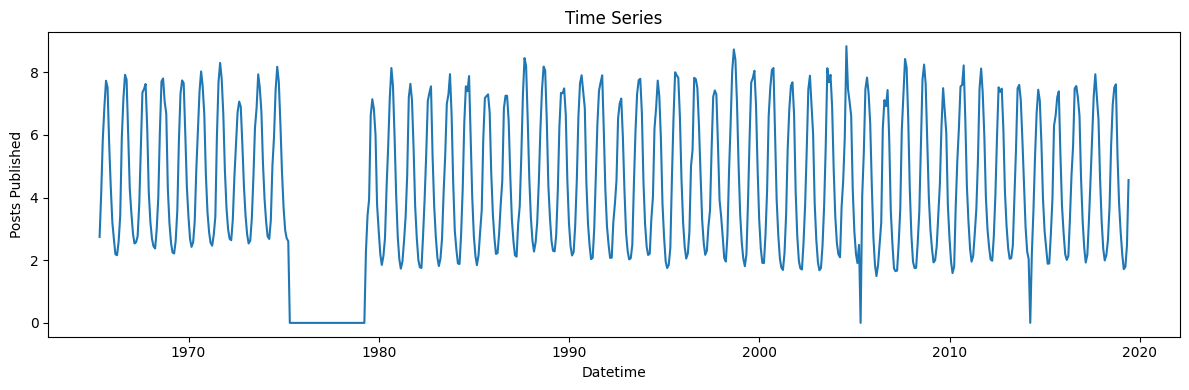

In [ ]:
# 7.Plotting the time series
monthly['WL(m)'] = monthly['WL(m)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(537, 1), Validation=(113, 1)


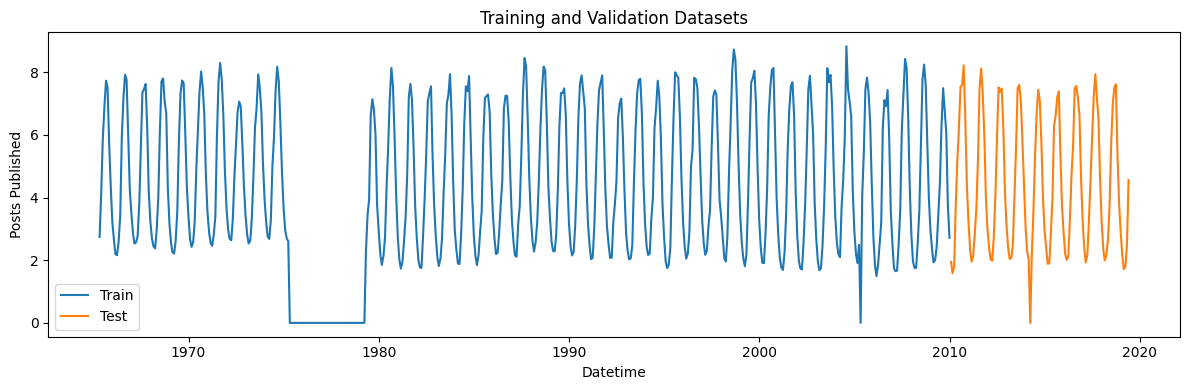

In [ ]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [ ]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [ ]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

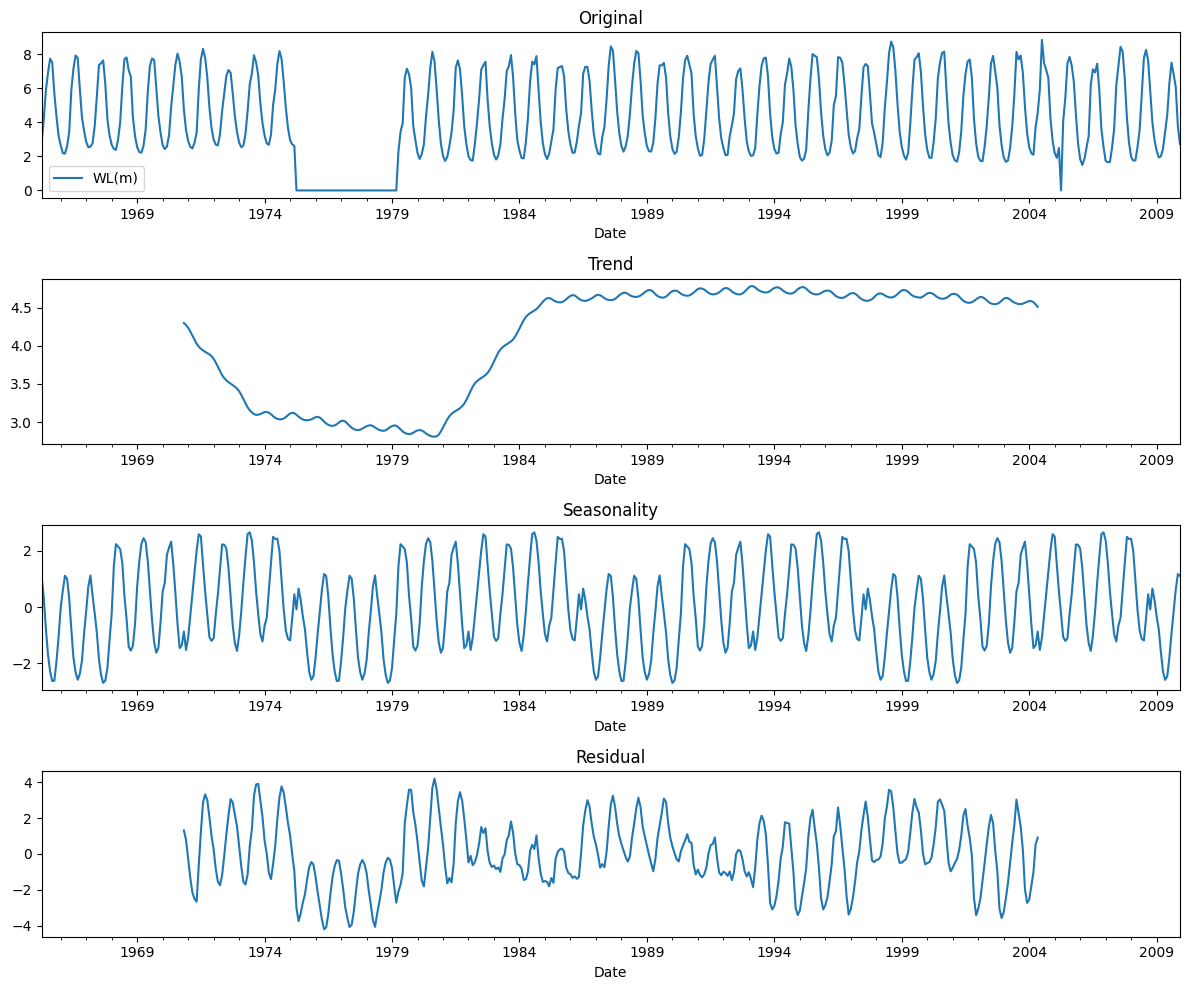

In [ ]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [ ]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

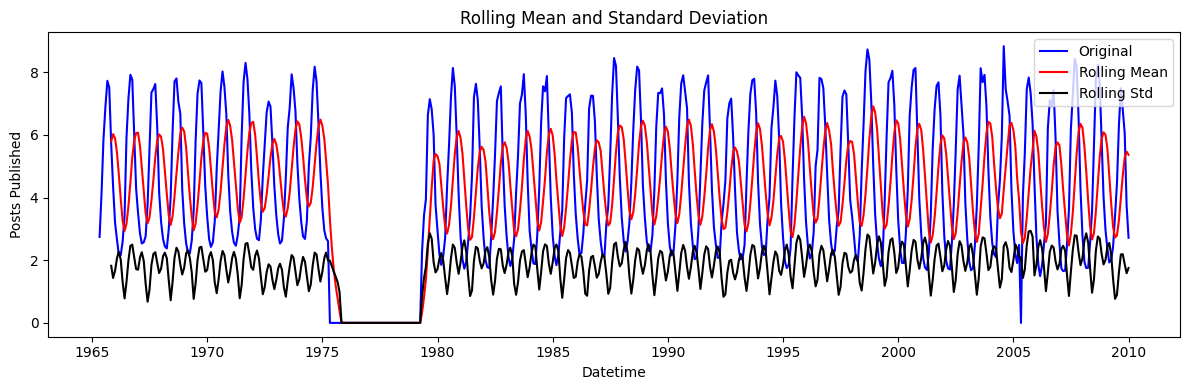

Results of Dickey-Fuller Test:
Test Statistic                  -2.792610
P-Value                          0.059337
#Lags Used                      15.000000
Number of Observations Used    521.000000
Critical Value (1%)             -3.442964
Critical Value (5%)             -2.867103
Critical Value (10%)            -2.569733
dtype: float64


In [ ]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()

    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')

# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL

In [ ]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [ ]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  WL(m)   No. Observations:                  537
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -465.279
Date:                Sun, 23 Jul 2023   AIC                            948.557
Time:                        16:37:21   BIC                            987.115
Sample:                    04-30-1965   HQIC                           963.642
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6482      0.069      9.393      0.000       0.513       0.783
ar.L2         -0.0875      0.048     -1.831      0.067      -0.181       0.006
ar.L3         -0.1572      0.047     -3.373      0.0

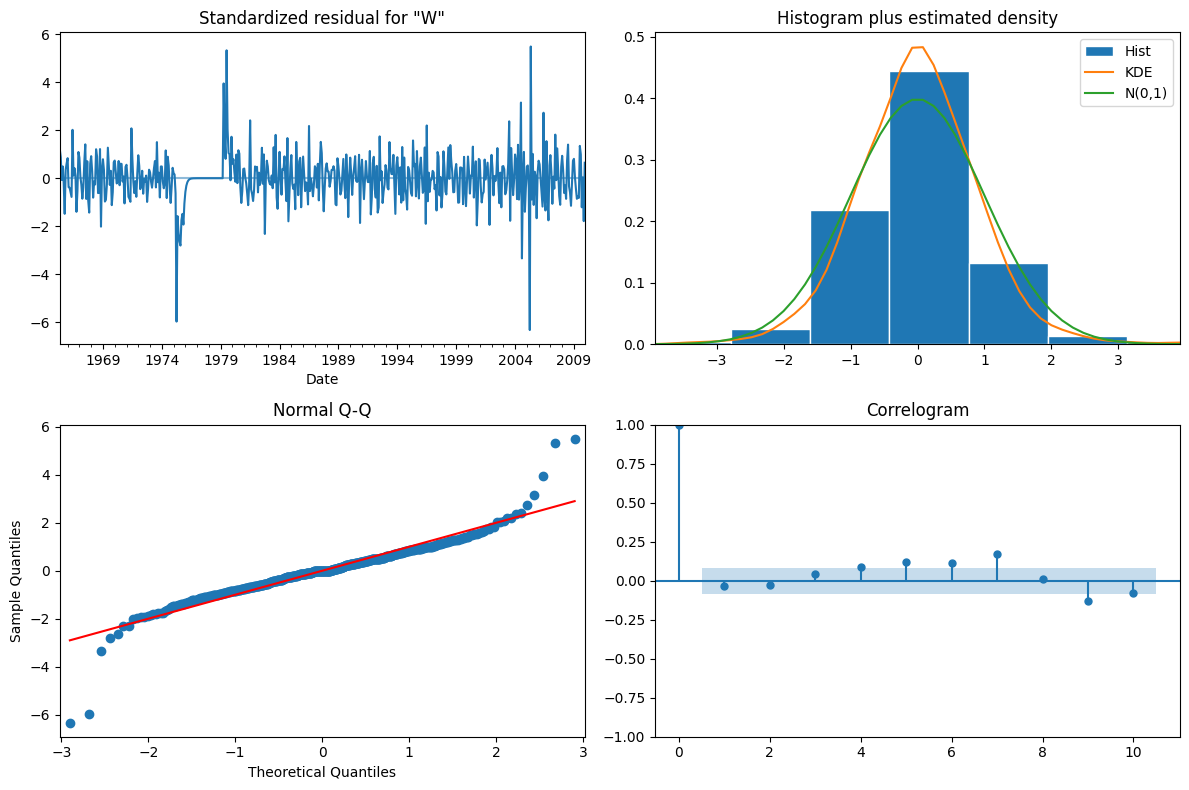

In [ ]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

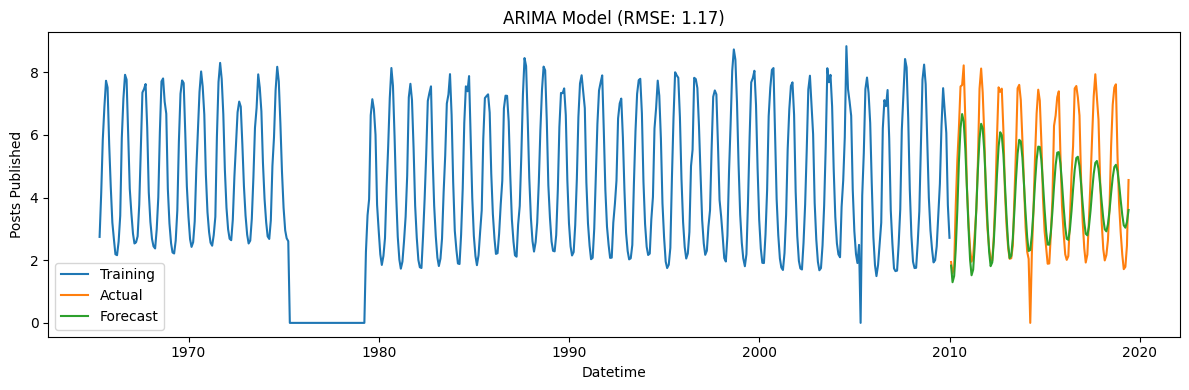

In [ ]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [ ]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31    1.828907
2010-02-28    1.298234
2010-03-31    1.498501
2010-04-30    2.343118
2010-05-31    3.611456
                ...   
2019-01-31    3.435800
2019-02-28    3.116734
2019-03-31    3.039709
2019-04-30    3.220281
2019-05-31    3.606107
Freq: M, Name: predicted_mean, Length: 113, dtype: float64


In [ ]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  1.1693829544835859


---------------------

SARIMAX MODEL

In [ ]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [ ]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              WL(m)   No. Observations:                  537
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                -363.748
Date:                            Sun, 23 Jul 2023   AIC                            761.497
Time:                                    16:40:31   BIC                            833.942
Sample:                                04-30-1965   HQIC                           789.867
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2105      0.216      0.976      0.329      -0.212       0.633
ar.L2          0.0990      0.044   

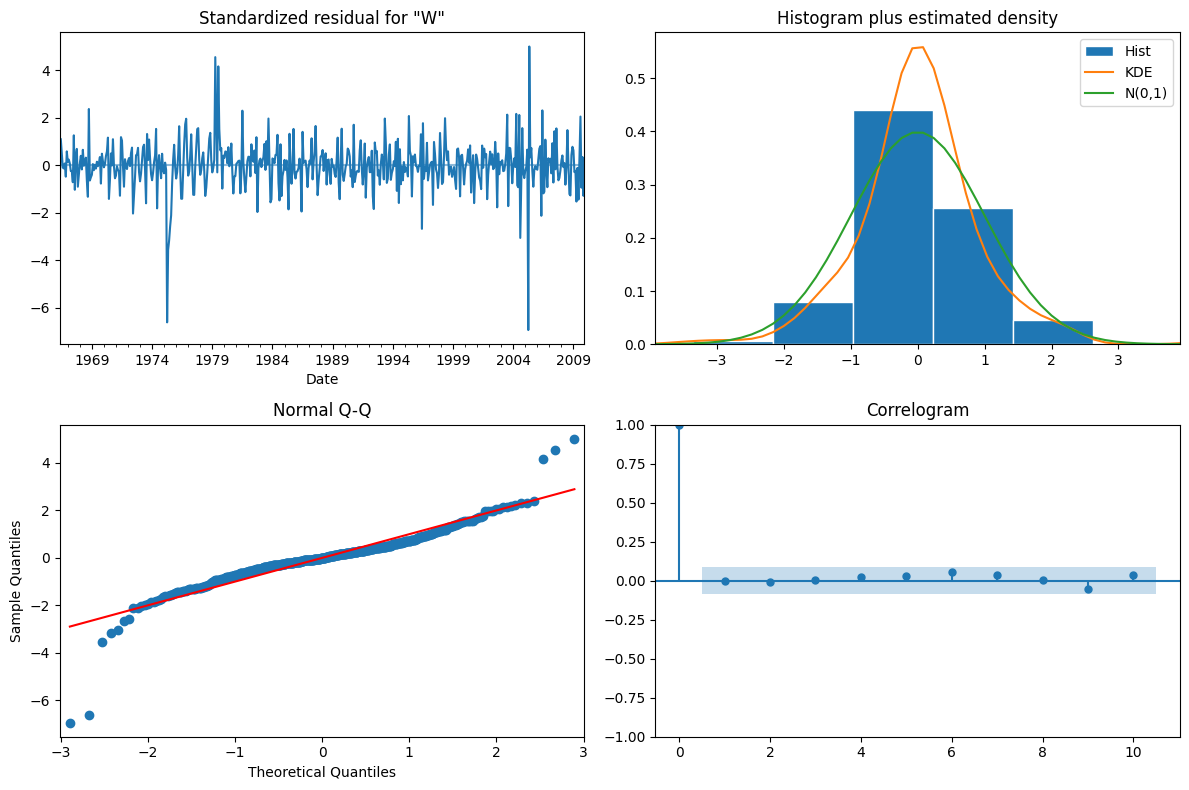

In [ ]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

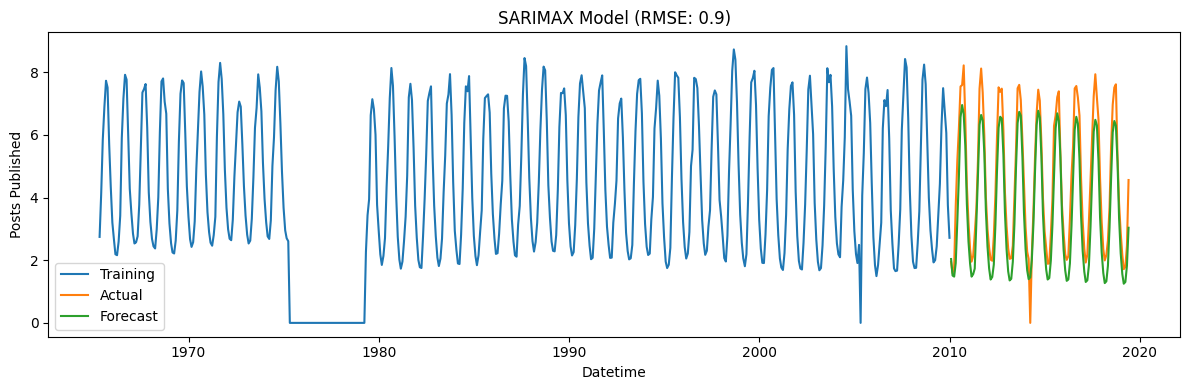

In [ ]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [ ]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31    2.038934
2010-02-28    1.512407
2010-03-31    1.478336
2010-04-30    1.907212
2010-05-31    3.258200
                ...   
2019-01-31    1.560574
2019-02-28    1.251099
2019-03-31    1.306882
2019-04-30    1.826171
2019-05-31    3.037642
Freq: M, Name: predicted_mean, Length: 113, dtype: float64


In [ ]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.901530189674533


-----------------------

PROPHET

In [ ]:
#Reading monthly data
df= pd.read_csv('Faridpur-Padma_monthly.csv')

In [ ]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1965-04-30,2.746000
1,1965-05-31,4.151290
2,1965-06-30,5.850667
3,1965-07-31,6.892258
4,1965-08-31,7.731290


In [ ]:
#prophet model Implement
prophet_model = Prophet()

In [ ]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0lurme5/cesz00_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0lurme5/3owzw93l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23184', 'data', 'file=/tmp/tmpx0lurme5/cesz00_3.json', 'init=/tmp/tmpx0lurme5/3owzw93l.json', 'output', 'file=/tmp/tmpx0lurme5/prophet_modelnmy4ik88/prophet_model-20230723164033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:40:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1965-04-30
1   1965-05-31
2   1965-06-30
3   1965-07-31
4   1965-08-31
..         ...
717 2025-01-31
718 2025-02-28
719 2025-03-31
720 2025-04-30
721 2025-05-31

[722 rows x 1 columns]


In [ ]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1965-04-30,4.735277,2.473012,3.440945,4.735277,4.735277,-1.789800,-1.789800,-1.789800,-1.789800,-1.789800,-1.789800,0.0,0.0,0.0,2.945477
1,1965-05-31,4.736165,3.728687,4.710377,4.736165,4.736165,-0.527402,-0.527402,-0.527402,-0.527402,-0.527402,-0.527402,0.0,0.0,0.0,4.208763
2,1965-06-30,4.737024,5.368097,6.357361,4.737024,4.737024,1.098173,1.098173,1.098173,1.098173,1.098173,1.098173,0.0,0.0,0.0,5.835196
3,1965-07-31,4.737911,6.963651,7.922826,4.737911,4.737911,2.690602,2.690602,2.690602,2.690602,2.690602,2.690602,0.0,0.0,0.0,7.428514
4,1965-08-31,4.738799,7.294608,8.263001,4.738799,4.738799,3.064634,3.064634,3.064634,3.064634,3.064634,3.064634,0.0,0.0,0.0,7.803433


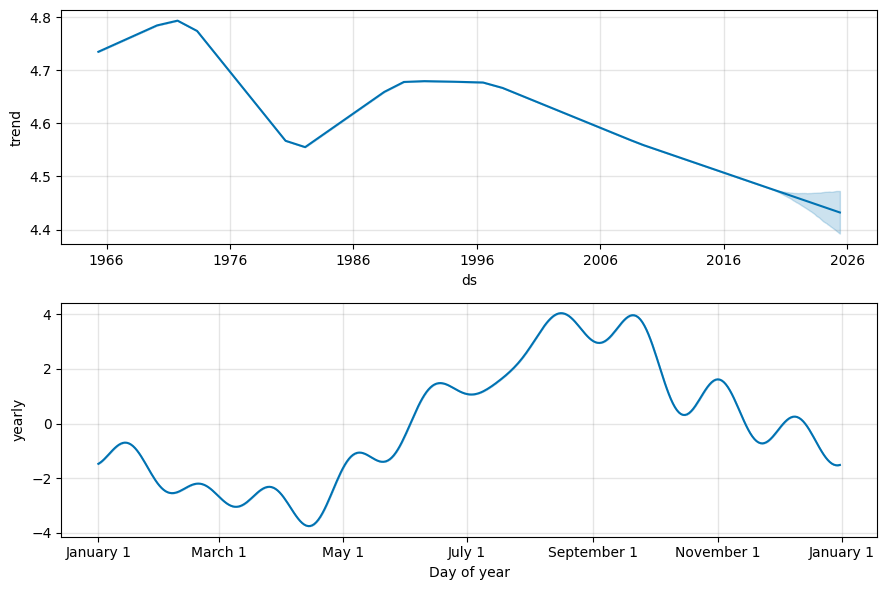

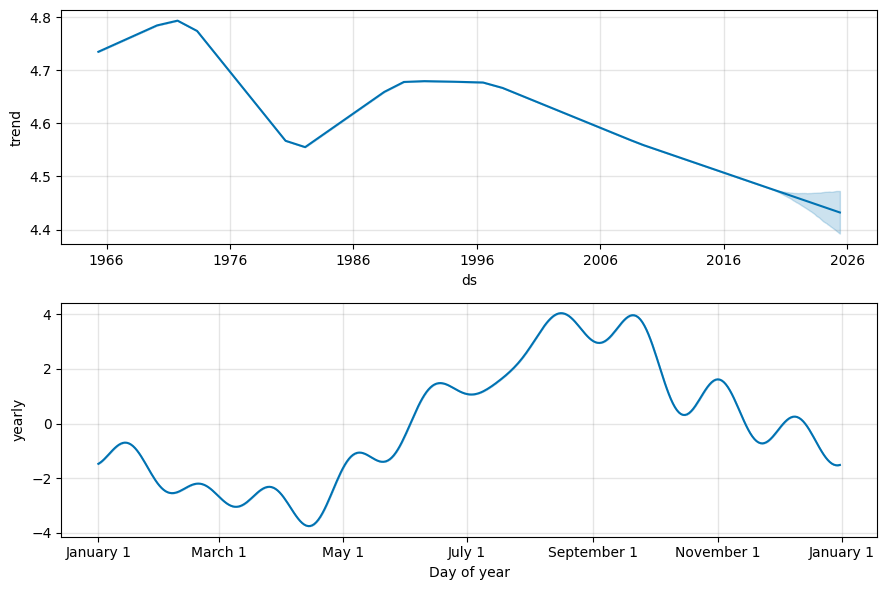

In [ ]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [ ]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe
fd=forecast_prophet_data.set_index('ds')
print(fd)

                yhat
ds                  
1965-04-30  2.945477
1965-05-31  4.208763
1965-06-30  5.835196
1965-07-31  7.428514
1965-08-31  7.803433
...              ...
2025-01-31  2.159363
2025-02-28  1.845726
2025-03-31  1.910323
2025-04-30  2.642999
2025-05-31  3.904719

[722 rows x 1 columns]


In [ ]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1965-04-30    2.945477
1965-05-31    4.208763
1965-06-30    5.835196
1965-07-31    7.428514
1965-08-31    7.803433
                ...   
2025-01-31    2.159363
2025-02-28    1.845726
2025-03-31    1.910323
2025-04-30    2.642999
2025-05-31    3.904719
Name: yhat, Length: 722, dtype: float64


In [ ]:
print(valid)

               WL(m)
Date                
2010-01-31  1.944000
2010-02-28  1.588286
2010-03-31  1.796516
2010-04-30  3.730267
2010-05-31  5.194516
...              ...
2019-01-31  2.171355
2019-02-28  1.715714
2019-03-31  1.789355
2019-04-30  2.462533
2019-05-31  4.562323

[113 rows x 1 columns]


In [ ]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-05-31']

In [ ]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.3822913701188003


-----------------

MODEL Comparison
----------

Testing

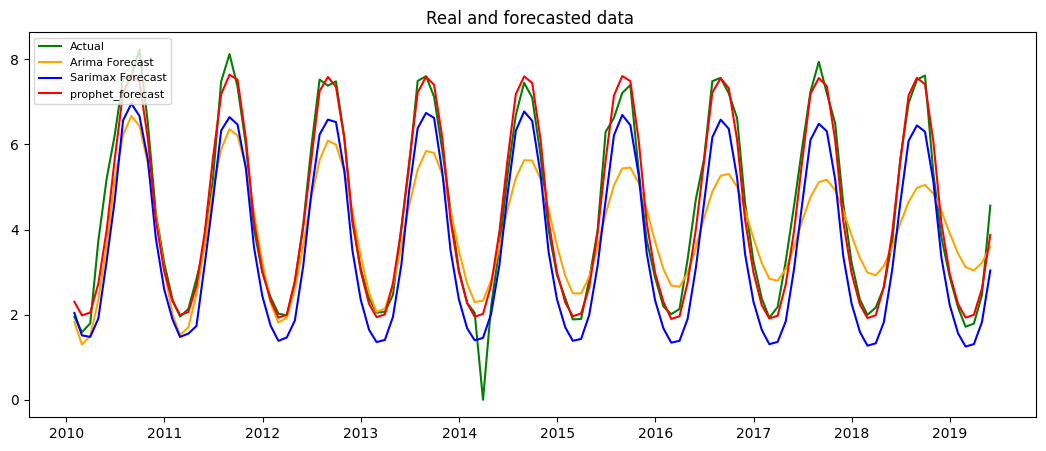

In [ ]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

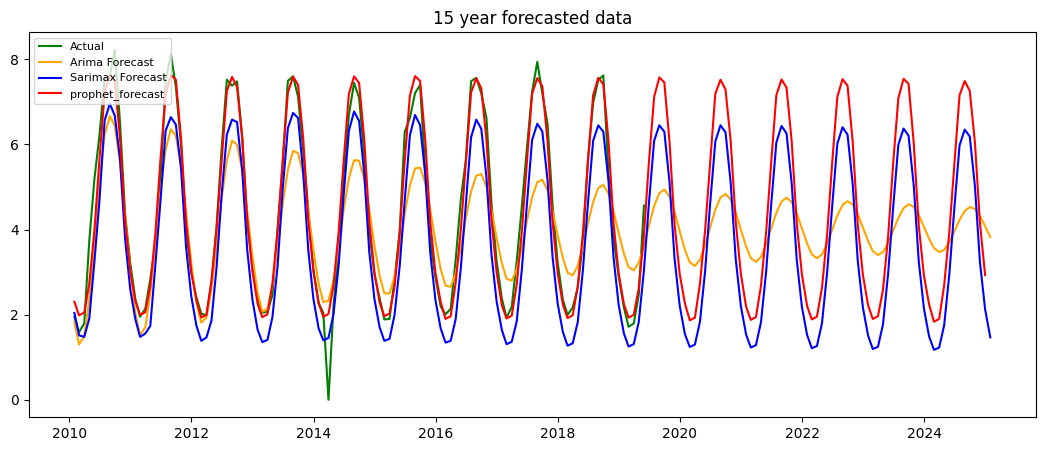

In [ ]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

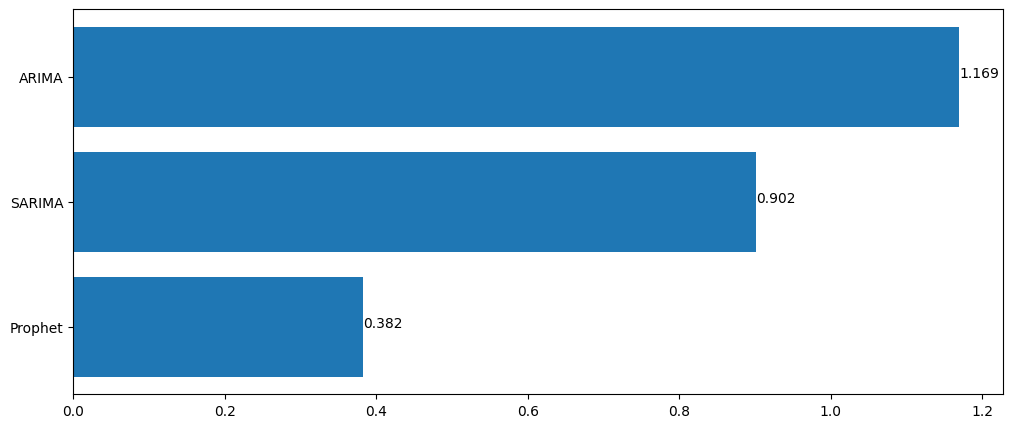

In [ ]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)

for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))

plt.show()

In [ ]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--


In [ ]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Faridpur-Padma-monthly_merged.csv")